# DESIGN OF EXPERIMENTS

This notebook introduces the codes required to do a 1-way design.

# Overview

A study should address the following:
1. What are the research questions? In this study, we want to understand how the kinetic contants affect oscillations in the Wolf Model.
1. What are the factors and levels? The factors are the kinetic constants. The levels are percentage changes in the values of the contants compared with the baseline.
1. What are the responses? In this study, the responses are the sustained oscillations in the model. These will be calculated using the Fast Fourier Transform (FFT).


This lecture illustrates a workflow for developing codes that run studies to do a one-factor-at-a-time (OFT) experimental design.
The running example is the model of glycolytic oscillations developed in J. Wolf et al., Biochem., 2000.

The function ``runStudy`` encapsulates the full workflow. This consists of:
1. running simulations for the factors and levels to be studied
1. calculating response values from the simulation results
1. constructing a table (dataframe) that reports the responses $y$ by factor level
1. calculating the $\mu$, $\alpha$ for design of experiments

The notebook contains codes for (1)-(3) for the Wolf model.
Responses are the oscillation frequency for glucose.

## Data rules
1. Simulation outputs are dataframes.
   * Names of molecules do not have "[", "]"
   * index is time
1. The names of chemical species do not have "[", "]"
1. Changes in parameter values are always in percents.

# Preliminaries

In [1]:
IS_COLAB = False

In [2]:
# Constants for standalone notebook
IS_COLAB = False
if not IS_COLAB:
    DIR = "/home/ubuntu/advancing-biomedical-models/common"  # Insert your local directory path
else:
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = "/content/drive/MyDrive/Modeling_Class_2021/Common"
import sys
sys.path.insert(0, DIR)

## Imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy import fftpack
import seaborn as sns
try:
    import tellurium as te
except:
    !pip install -q tellurium==2.2.0

## Constants

In [4]:
# Constants
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value
WOLF_PATH = os.path.join(DIR, "Jana_WolfGlycolysis.antimony")
with open(WOLF_PATH, "r") as fd:
    WOLF_MODEL = fd.readlines()
WOLF_MODEL = "".join(WOLF_MODEL)

In [5]:
print(WOLF_MODEL)

// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceralde

## Helper Functions

In [6]:
def arrToDF(arr):
    """
    Converts a NamedArray to a DataFrame.
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    return pd.DataFrame(arr, columns=columns)

# TESTS
rr = te.loada("A -> B; 1; A=0; B=0; a=2")
arr = rr.simulate()
df = arrToDF(arr)
assert(isinstance(df, pd.DataFrame))
trues = ["[" not in c and "]" not in c for c in df.columns]
assert(all(trues))

# Wolf Model

We begin with an exploration of the Wolf model to understand its parameters and to determine what responses should be reported by an experiment.

In [7]:
# Constants used in the analysis of the Wolf model
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_FACTORS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]
rr = te.loada(WOLF_MODEL)
WOLF_DF = arrToDF(rr.simulate(START, END, NUMPT))

## Exploration of the Model

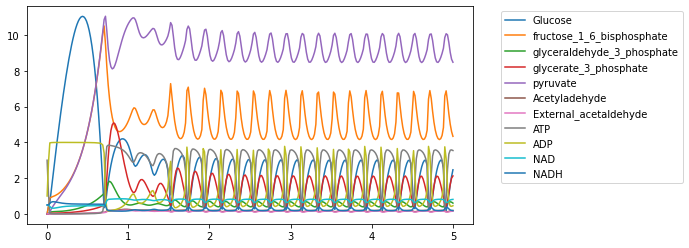

In [8]:
def timePlots(df=WOLF_DF, title="", isPlot=True):
    """
    Plots floating species over time.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame for results of simulation of Wolf Model
    title: str
        Title of plot
    isPlot: bool
    """
    fig, ax = plt.subplots(1, figsize=(8, 4))
    arr = df.values
    colnames = df.columns
    p = ax.plot(arr[:, 0], arr[:,1:])
    _ = ax.legend(p, colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
    if isPlot:
        plt.show()
    
# Tests
timePlots(isPlot=False)

# Running Simulations With Changes in Parameter Values

The first thing we need to do is to be able to run an experiment when a parameter is changed.
We consider multiple levels for the parameter value.

In [9]:
def runSimulations(parameter, percents, isPlot=True):
    """
    Runs experiments and produces plots for the percent changes in parameter values.

    Parameters
    ----------
    parameter: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
          
    Returns
    -------
    dict:
        key: pct
        value: DataFrame
    """
    roadrunner = te.loada(WOLF_MODEL)
    baseValue = roadrunner[parameter]
    if not parameter in roadrunner.keys():
        raise ValueError("Unknown parameter name: %s" % parameter)
    resultDct = {}
    for percent in percents:
        roadrunner.resetAll()
        percent = max(percent, SMALLEST_PCT)
        frac = 0.01*percent
        newValue = baseValue*(1 + frac)
        roadrunner[parameter] = newValue
        df = arrToDF(roadrunner.simulate(START, END, NUMPT))
        title = "%s: %f (%d%%)" % (parameter, newValue, percent)
        resultDct[percent] = df
        if isPlot:
            timePlots(df=df, title=title)
    return resultDct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations("J1_Ki", percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)

Here's an example of using these codes.

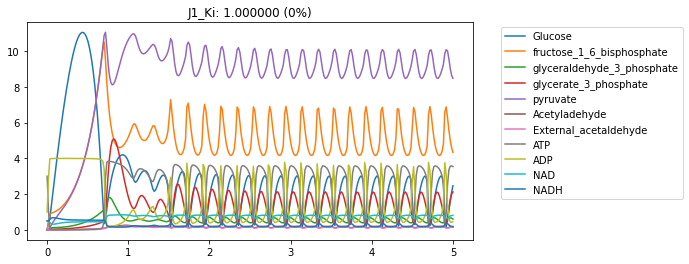

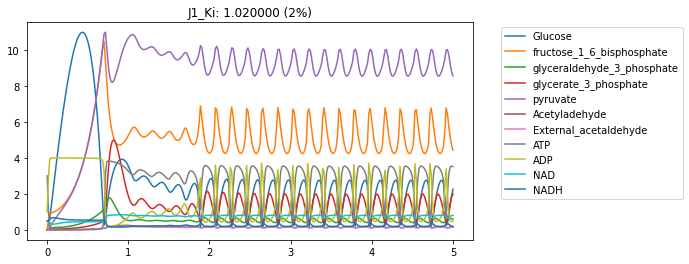

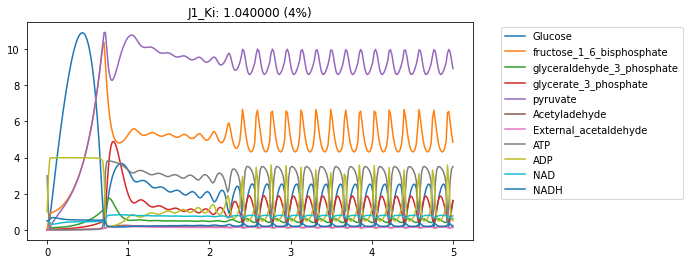

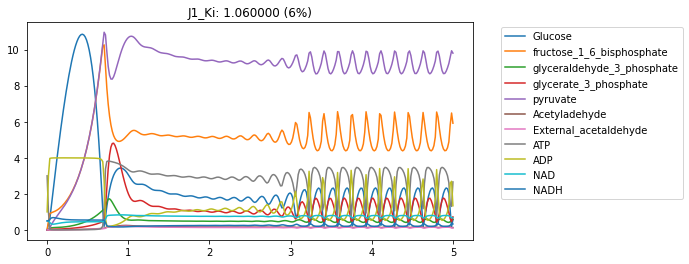

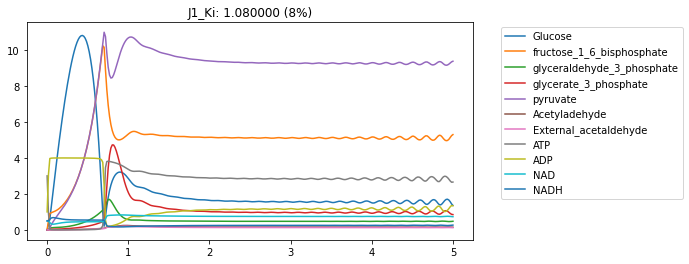

In [10]:
# Experiments 
changes = 2*np.array(range(5))
length = len(changes)
_ = runSimulations("J1_Ki", changes)

**Questions**
1. What happens when J1_Ki is reduced?
1. Do other parameters behave in a similar way in that the onset of cyclic behavior is delayed with a larger change?
1. What metric(s) should we use to quantify the effect on cyclic behavior?

# Calculating Responses

For the Wolf model, our response is *not* a collection of simulation time series.
Instead, it is the oscillation frequency detected in the time series for a particular molecule.

## Fast Fourier Transform (FFT)


How do we transform the output of the simulation into the desired response?

The most common way to characterize oscillations in a time series is the Fast Fourier Transform (FFT).
The FFT provides a two arrays. The first is a list of frequencies. The second is a coefficient whose magnitude indicates the
contribution of that frequency to the time series.
We are looking for the frequency that has the largest contribution, assuming that it's magnitude exceeds a minimum value.

In [11]:
def calculateFft(molecule, dataDF, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    dataDF: DataFrame
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    times = dataDF[TIME].values
    values = dataDF[molecule].values
    numPoint = len(times)
    count = numPoint - offset
    endTime = times[-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("Glucose", WOLF_DF)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude

Which frequencies are the largest?

In [12]:
idxs = list(np.argsort(fftValues))
idxs.reverse()
freqs[idxs]

array([  5.1,  -5.1, -10.2,  10.2,  -4.8,   4.8,  15.3, -15.3,   5.4,
        -5.4,  -9.9,   9.9,   4.5,  -4.5,   5.7,  -5.7,   9.6,  -9.6,
        -6. ,   6. ,   4.2,  -4.2, -20.4,  20.4, -15. ,  15. ,  10.5,
       -10.5,   9.3,  -9.3,  -3.9,   3.9,   9. ,  -9. , -14.1,  14.1,
         3.6,  -3.6,  14.7, -14.7, -11.1,  11.1, -10.8,  10.8,  -8.7,
         8.7,  -6.3,   6.3,   6.6,  -6.6,  29.4, -29.4,  25.5, -25.5,
         8.1,  -8.1,  24.3, -24.3,  19.2, -19.2,   3.3,  -3.3,   3. ,
        -3. ,   6.9,  -6.9,  20.1, -20.1,   7.2,  -7.2,   8.4,  -8.4,
       -14.4,  14.4, -13.8,  13.8,   7.5,  -7.5,   7.8,  -7.8,   0.9,
        -0.9,  13.2, -13.2,  -2.7,   2.7, -25.2,  25.2,  -0.6,   0.6,
        -0.3,   0.3, -11.7,  11.7, -11.4,  11.4,  13.5, -13.5,  16.2,
       -16.2,  15.6, -15.6,   2.4,  -2.4,  12. , -12. , -19.8,  19.8,
        12.3, -12.3, -21.3,  21.3, -12.6,  12.6,  -1.8,   1.8, -12.9,
        12.9,  -2.1,   2.1,  15.9, -15.9, -18.9,  18.9,   1.5,  -1.5,
        24.9, -24.9,

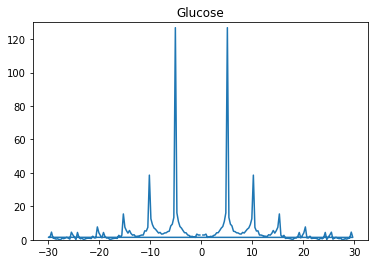

In [13]:
def plotFft(molecule, dataDF=WOLF_DF, ax=None, isPlot=True, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    dataDF: DataFrame
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, dataDF=dataDF, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])
    if isPlot:
        plt.show()
    
# Tests
plotFft("Glucose", isPlot=False)  # "Smoke" test

## Calculate peak frequency

The response we'll use is the frequency with the largest peak.
We want to calculate this frequency for the chemical species.

In [14]:
def calculatePeakFrequency(molecule, dataDF, numDelete=0, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    dataDF: DataFrame
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    float: peak frequency
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        newLst = lst1.extend(lst2)
        return np.array(lst1)    
    #
    frequencies, amplitudes = calculateFft(molecule, dataDF)
    # Delete the largest N values
    for _ in range(numDelete):
        maxIdx = getIndexOfMax(amplitudes)
        frequencies = deleteArrayElement(frequencies, maxIdx)
        amplitudes = deleteArrayElement(amplitudes, maxIdx)
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx]

# TESTS
assert(calculatePeakFrequency("Glucose", WOLF_DF) > 0)

In [15]:
calculatePeakFrequency("Glucose", WOLF_DF)

5.1

## Run simulations and calculate responses

In [16]:
WOLF_FACTORS

['J0_inputFlux',
 'J1_k1',
 'J1_Ki',
 'J1_n',
 'J2_k',
 'J3_k',
 'J4_kg',
 'J4_kp',
 'J4_ka',
 'J4_kk',
 'J5_k',
 'J6_k',
 'J7_k',
 'J8_k1',
 'J8_k2',
 'J9_k',
 'J10_k']

In [17]:
def calculateFrequencyResponses(factors=WOLF_FACTORS, percents=[0], molecule="Glucose"):
    """
    Calculates the frequency responses for a 1WD for the factors and 
    levels expressed as percents.

    Parameters
    ----------
    factors: list-str (kinetic constants)
    percents: float

    Returns
    -------
    pd.DataFrame
       rows: factor
       columns: percents
       values: frequency
    """
    percentDct = {p: [] for p in percents}
    for factor in factors:
        dataDct = runSimulations(factor, percents, isPlot=False)
        # Calculate the FFT for all percents for this factor
        for percent in dataDct.keys():
            frequency = calculatePeakFrequency(molecule, dataDct[percent])
            percentDct[percent].append(frequency)
    return pd.DataFrame(percentDct, index=factors)

df = calculateFrequencyResponses(percents=[-2, 0, 2])
assert(isinstance(df, pd.DataFrame))

In [18]:
PERCENTS = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
RESPONSE_DF = calculateFrequencyResponses(percents=PERCENTS)
RESPONSE_DF

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,7.5,6.3,5.7,5.4,5.1,4.8,4.5,4.5,0.3
J1_k1,4.5,4.8,4.8,5.1,5.1,5.1,5.1,5.4,5.7
J1_Ki,3.0,3.9,4.5,4.8,5.1,5.4,5.7,0.3,0.3
J1_n,0.3,0.3,0.3,5.4,5.1,4.8,4.5,3.9,3.0
J2_k,4.8,4.8,5.1,5.1,5.1,5.1,5.1,5.1,5.4
J3_k,4.8,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_kg,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_kp,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_ka,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1
J4_kk,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1,5.1


**Questions**
1. Which parameters show an effect on frequency for the levels considered?
1. Of these, which parameter values are inversely related to frequency?

# Calculating DOE Parameters

For a 1WD, the DOE parameters are $\mu$ and $\alpha_{i, k_i}$.
These parameters are calculated for each response.
In the Wolf model, a response is the peak frequencies of a chemical species.
Recall that:
* $\mu$ is the baseline for the simulation.
* $\alpha_{i, k_i} = y_{i, k_i} - \mu$

In [19]:
def calculate1WDParameters(responseDF):
    """
    Calculates the design of experiment parameters for a 1-Way Design.
    Assumes that there is a level of 0.

    Parameters
    ----------
    responseDF: pd.DataFrame
        column: levels
        index: factors
        values: y_i,k_i
    
    Returns
    -------
    float: Mu
    pd.DataFrame
        columns: levels (k_i)
        index: factors (i)
        values: \alpha_i,k_i
    """
    mu = responseDF.loc["J1_k1", 0]
    resultDF = responseDF - mu
    return mu, resultDF

# TESTS
mu, responseDF = calculate1WDParameters(RESPONSE_DF)
assert(np.abs(mu - 5.1) < 0.1)
assert(isinstance(responseDF, pd.DataFrame))

In [20]:
mu, responseDF = calculate1WDParameters(RESPONSE_DF)
responseDF

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,2.4,1.2,0.6,0.3,0.0,-0.3,-0.6,-0.6,-4.8
J1_k1,-0.6,-0.3,-0.3,0.0,0.0,0.0,0.0,0.3,0.6
J1_Ki,-2.1,-1.2,-0.6,-0.3,0.0,0.3,0.6,-4.8,-4.8
J1_n,-4.8,-4.8,-4.8,0.3,0.0,-0.3,-0.6,-1.2,-2.1
J2_k,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.3
J3_k,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Questions**
1. In many cases $\alpha_{i,k_i}$ is 0. What does this mean?

# Running a Study

A study is a collection of experiments in which one or more factors are set to different levels.
For a 1WD, only one factor at a time is changed.

In [21]:
def runStudy(factors=WOLF_FACTORS, percents=[0], molecule="Glucose"):
    """
    Runs a 1WD for the factors and levels expressed as percents.

    Parameters
    ----------
    factors: list-str (kinetic constants)
    percents: float

    Returns
    -------
    float: mu
    pd.DataFrame: alpha_i, k_i
       rows: factor
       columns: percents
       values: frequency
    """
    df = calculateFrequencyResponses(factors=factors, percents=percents,
                                     molecule=molecule)
    return calculate1WDParameters(df)

mu, df = runStudy(percents=[-2, 0, 2])
assert(isinstance(df, pd.DataFrame))
assert(isinstance(mu, float))

Below we calculate the effect of parameter changes on NADH.

In [22]:
mu, df = runStudy(percents=[-20, -10, -5, -2, 0, 2, 5, 10, 20], molecule="NADH")
df

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,2.1,1.2,0.6,0.3,0.0,-0.3,-0.6,-0.6,-4.8
J1_k1,-0.6,-0.3,-0.3,0.0,0.0,0.0,0.0,0.3,0.6
J1_Ki,-2.1,-1.2,-0.6,-0.3,0.0,0.3,0.6,-4.8,-4.8
J1_n,-4.8,-4.8,-4.8,0.3,0.0,-0.3,-0.6,-1.2,-2.1
J2_k,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.3
J3_k,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Visualizing the Results

Even for a model of modest size, the number of DOE $\alpha$ parameters is overwhelming.
Analyzing these parameters is greatly facilitated by using appropriate visualizations.
For tabular data, a heatmap is a natural visualization.

## Example of a heatmap in python

The example below generates a heatmap from a pandas DataFrame. 
The horizontal axis are the column names; the vertical axis are the values of the index of the DataFrame.
Values are encoded as a heat representation from 0 to 1.0.

In [23]:
# DataFrame
df = pd.DataFrame({"a": np.random.random(5), "b": np.random.random(5)})
df.index = [10*v for v in range(len(df))]
df

,a,b
0,0.039073,0.071008
10,0.887053,0.566898
20,0.236477,0.253937
30,0.114329,0.546415
40,0.027624,0.074426


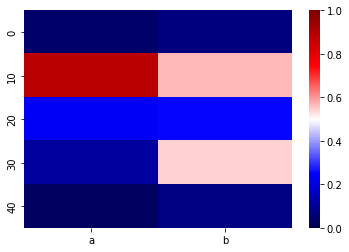

In [24]:
# Generating the heatmap
_ = sns.heatmap(df, cmap='seismic', vmin=0, vmax=1)

## Heatmap for 1WD

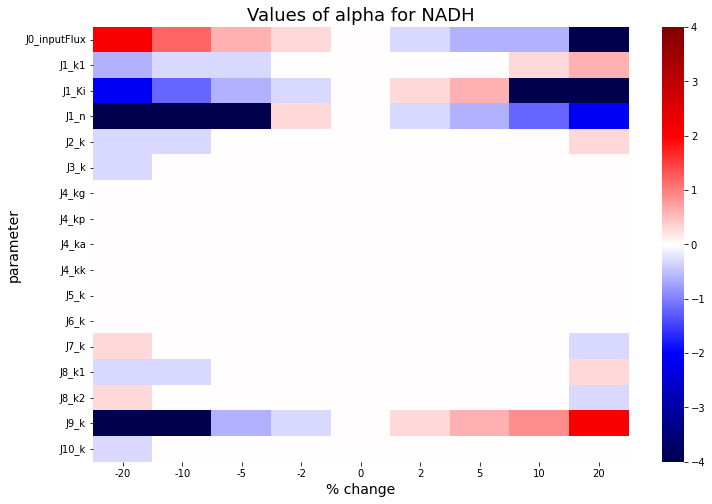

In [25]:
# Visualization for NADH
mu, df = runStudy(percents=[-20, -10, -5, -2, 0, 2, 5, 10, 20], molecule="NADH")
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.heatmap(df, cmap="seismic", vmin=-4, vmax=4, ax=ax)
plt.ylabel("parameter", fontsize=14)
plt.xlabel("% change", fontsize=14)
_ = plt.title("Values of alpha for NADH", fontsize=18)

# Exercise

Compare the effect of parameters on Glucose with their effects on NADH. Which parameters have more of an effect on Glucose than on NADH?
* Hint: Manipulate the dataframes returned from ``runStudy``

## Answer

In [26]:
PERCENTS = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
_, df1 = runStudy(percents=PERCENTS, molecule="Glucose")
_, df2 = runStudy(percents=PERCENTS, molecule="NADH")

In [27]:
# Effects
df1 - df2

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J1_k1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J1_Ki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J1_n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J2_k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J3_k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_ka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J4_kk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
